## Load the data

In [1]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from scipy.stats import nbinom, poisson
from time import sleep
from tqdm import tqdm
import warnings


def check_Actuals(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        return False
    else:
        return True

# check if the last month of a country in the feature dataset is 3 months before the first month that has to be predicted
def check_last_featureMonth(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        raise ValueError('country does not have actuals')


    # last month of the feature dataset
    last_feature_month = country_feature_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[-1]

    # first month of the actual dataset
    first_actual_month = country_actual_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[0]

    # if the last month of the feature dataset in the country does not match the first of the actuals return false
    if (first_actual_month - 3) != last_feature_month:
        return False
    else:
        return True


# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])

country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

In [2]:
#features_df_list[0]['data'].xs(400, level='month_id').tail(30)

## Länder aussortieren
die nicht gefordert sind und
*  die keine actuals haben
*  die zu wenig Beobachtungen haben

In [3]:
relative_path_countrylist = os.path.join('..', 'data', 'country_list.csv')
path_countrylist = os.path.join(current_dir, relative_path_countrylist)

# CSV-Datei einlesen und als Pandas-Datensatz speichern
countryList_prediction = pd.read_csv(path_countrylist)
country_list_views = countryList_prediction.loc[:,'country_id'].values.tolist() 

month_list = []
countries_to_remove = []
for country_id in country_list:

    if country_id in country_list_views:
        feature_data = country_feature_group_list[0].get_group(country_id)

        # numbers of months from the feature dataset
        month_list_feature_data_original = feature_data.index.get_level_values('month_id').tolist()
        number_months_feature_data = len(month_list_feature_data_original) 

        if check_Actuals(country_id, 0):
            if not check_last_featureMonth(country_id, 0): 
                month_list.append([str(country_id) +' last month missing'])
            else:
                month_list.append([number_months_feature_data, country_id])
        else:
            month_list.append(str(country_id) + ' no actuals')
    else:
        countries_to_remove.append(country_id)

country_list = list(set(country_list) - set(countries_to_remove))
month_list.sort()

In [4]:
month_list

[[76, 245],
 [76, 246],
 [116, 232],
 [116, 233],
 [137, 231],
 [186, 176],
 [186, 209],
 [209, 124],
 [209, 131],
 [261, 242],
 [277, 144],
 [294, 56],
 [294, 57],
 [298, 98],
 [298, 102],
 [307, 83],
 [307, 84],
 [307, 103],
 [311, 63],
 [311, 65],
 [311, 117],
 [311, 125],
 [311, 126],
 [312, 86],
 [313, 122],
 [314, 92],
 [314, 111],
 [314, 113],
 [314, 114],
 [314, 137],
 [315, 110],
 [315, 115],
 [315, 123],
 [315, 134],
 [325, 184],
 [332, 163],
 [332, 170],
 [334, 1],
 [334, 2],
 [334, 3],
 [334, 4],
 [334, 5],
 [334, 6],
 [334, 7],
 [334, 8],
 [334, 9],
 [334, 10],
 [334, 11],
 [334, 12],
 [334, 13],
 [334, 14],
 [334, 16],
 [334, 17],
 [334, 18],
 [334, 19],
 [334, 20],
 [334, 21],
 [334, 22],
 [334, 23],
 [334, 24],
 [334, 25],
 [334, 26],
 [334, 27],
 [334, 28],
 [334, 29],
 [334, 30],
 [334, 31],
 [334, 32],
 [334, 33],
 [334, 34],
 [334, 35],
 [334, 36],
 [334, 37],
 [334, 38],
 [334, 39],
 [334, 40],
 [334, 41],
 [334, 42],
 [334, 43],
 [334, 45],
 [334, 46],
 [334, 47],

check for possible Nan's in all Datasets

In [5]:
# check for nan's
for featurelist in features_df_list:
    is_na_series = featurelist['data'].isna().sum()

    for i in range(len(is_na_series)):
        if is_na_series[i] > 0 :
            print(str(is_na_series.index[i]) + ': ' + str(is_na_series[i]))

### Data preparation for the Neural Net

In [6]:
import math
from sklearn import preprocessing
### function used to calculate w_max, number of rolling windows etc.
# length of a whole window (containing w input months and 12 acutal months)
def rollingWindowLength(w):
    return w + 2 + 12

def number_valid_months(numberMonths_available, w, relative_validation_size):

    number_train_valid_months = numberMonths_available - w
    number_valid_months = math.floor(number_train_valid_months * relative_validation_size)

    return number_valid_months

# number of months available for training (after removing the validation and test months)
def number_train_months(numberMonths_available, w, relative_validation_size):

    valid_months = number_valid_months(numberMonths_available, w, relative_validation_size)

    #  all months feature data   -  validate set    -   test set input
    return numberMonths_available - valid_months - w


def number_rolling_windows(numberMonths_available, w):
    return max(0,numberMonths_available - rollingWindowLength(w) + 1)



def find_max_W(numberMonths_available, w_min, w_max, relative_validation_size):

    # with "w_min" and the "relative_validation_size" there has to be at least one validation window
    number_valid_months_wmin = number_valid_months(numberMonths_available, w_min, relative_validation_size)

    if number_rolling_windows(number_valid_months_wmin, w_min) == 0:
        raise ValueError('not enough months for one validation window with w_min = ' + str(w_min))

    # with "w_min" and the "relative_validation_size" there has to be at least one train window
    number_train_months_wmin = number_train_months(numberMonths_available, w_min, relative_validation_size)

    if number_rolling_windows(number_train_months_wmin, w_min) == 0:
        raise ValueError('not enough months for one training window with w_min = ' + str(w_min))

    # find the maximal w
    max_W = w_max
    number_valid_months_wmax = number_valid_months(numberMonths_available, max_W, relative_validation_size)
    number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months_wmax, max_W)

    number_train_months_wmax = number_train_months(numberMonths_available, max_W, relative_validation_size)
    number_train_rollwindows_wmax = number_rolling_windows(number_train_months_wmax, max_W)

    # calculate w_max so that the number of rolling windows for the validation set is >= 1
    # and that
    # the number of rolling windows for the train set is >= 1
    while (number_valid_rollwindows_wmax == 0 or number_train_rollwindows_wmax == 0) and max_W > w_min:
        max_W -= 1
        number_valid_months_wmax = number_valid_months(numberMonths_available, max_W, relative_validation_size)
        number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months_wmax, max_W)

        number_train_months_wmax = number_train_months(numberMonths_available, max_W, relative_validation_size)
        number_train_rollwindows_wmax = number_rolling_windows(number_train_months_wmax, max_W)

    return max_W


### prediction task for year 2018
prediction_year = '2018'
dataset_index = actual_years.index(prediction_year)
s = 14 # month to predict element out of [3,14]

rel_validation_size = 0.3 # percentual size of the validation set

# the maximal w (months to estimate the fatalities from) is set to e.g. 3 years (36 months)
w_max = 36 
# BUT: If w_max=36 leads to a number of rolling windows < 1 in the validation dataset,
# w_max is set to the maximal w, so that the number of rolling windows is >= 1
# => this step is done below in the section for each country

# to calculate the w_max the w_min has to be set as well
w_min = 2


## country 223
prediction_country_id = 223 #220  245

# check if the last month of the country in the feature dataset is 3 months before the first month that has to be predicted
if not check_last_featureMonth(prediction_country_id, dataset_index):
    raise ValueError('last month is not contained in the data')

## load datasets
feature_data = country_feature_group_list[dataset_index].get_group(prediction_country_id)
actual_data = country_actual_group_list[dataset_index].get_group(prediction_country_id)

feature_data = feature_data.drop(columns='gleditsch_ward')


# numbers of months from the feature dataset
month_list_feature_data = feature_data.index.get_level_values('month_id').tolist()
first_month = min(month_list_feature_data)
last_month = max(month_list_feature_data)
number_months_feature_data = len(month_list_feature_data) # number of months in the feature dataset

# find w_max (as mentioned above, if there are not enoug months, the w_max has to be < 36)
w_max = find_max_W(number_months_feature_data, w_min, w_max, rel_validation_size)

w = w_max

### split data in train-, validation- and test-dataset
""" The data sizes are calculated in a way, that missing months are no problem. Additionaly due to the fact, that the data is sorted
    regarding months, this step can be skipped. """

# length of the maximum rolling window and the used "unreal" acutals starting 3 months after the last used month
roll_window_len = rollingWindowLength(w)
n_train_months = number_train_months(number_months_feature_data, w, rel_validation_size)
n_valid_months = number_valid_months(number_months_feature_data, w, rel_validation_size)
n_test_months = w

month_list_train = month_list_feature_data[0:n_train_months]
month_list_valid = month_list_feature_data[n_train_months:(n_train_months+n_valid_months)]
month_list_test = month_list_feature_data[number_months_feature_data-n_test_months:]

def TrainValid_ArrayXY_split(train_months, w, month_list, data_feature):
    X = []
    Y = []

    number_rolling_windows_train = number_rolling_windows(train_months, w)

    for i in range(0, number_rolling_windows_train):
        starting_month_features = month_list[i]

        index_ending_month_features = i + w - 1
        ending_month_features = month_list[index_ending_month_features]

        starting_month_unrActuals = month_list[index_ending_month_features + 3]
        ending_month_unrActuals = month_list[index_ending_month_features + 14]

        window_features = data_feature.loc[slice(starting_month_features, ending_month_features), :] # 'ged_sb':'ged_sb_tlag_4'  ||excluding "unreal" actuals
        window_actuals = data_feature.loc[slice(starting_month_unrActuals, ending_month_unrActuals), 'ged_sb'].iloc[s - 3] # "unreal" actuals


        normalized_window_features = preprocessing.normalize(window_features)
        window_features_array = np.array([normalized_window_features.flatten()])[0]

        window_actual_array = np.array([window_actuals])

        X.append(window_features_array)
        Y.append(window_actual_array)

    X = np.array(X)
    Y = np.array(Y)

    return X,Y

def Test_ArrayXY_split(month_list, data_feature, data_actual):
    X = []
    Y = []

    starting_month_test = month_list[0]
    ending_month_test = month_list[-1]

    window_features_test = data_feature.loc[slice(starting_month_test, ending_month_test), :] # all w features to predict the fatalities
    window_actuals_test = data_actual.iloc[s - 3].values # real actuals

    normalized_window_features_test = preprocessing.normalize(window_features_test)
    window_features_array_test = np.array([normalized_window_features_test.flatten()])[0]

    window_actual_array_test = window_actuals_test

    X.append(window_features_array_test)
    Y.append(window_actual_array_test)

    X = np.array(X)
    Y = np.array(Y)

    return X,Y


## training dataset------
X_train, Y_train = TrainValid_ArrayXY_split(n_train_months, w, month_list_train, feature_data)

## validation dataset--------
X_validate, Y_validate = TrainValid_ArrayXY_split(n_valid_months, w, month_list_valid, feature_data)

## test dataset-------
X_test, Y_test = Test_ArrayXY_split(month_list_test, feature_data, actual_data)


print('(first, last) train month: (' + str(month_list_train[0])+','+str(month_list_train[-1])+')')
print('(first, last) validate month: (' + str(month_list_valid[0])+','+str(month_list_valid[-1])+')')
print('(first, last) test month: (' + str(month_list_test[0])+','+str(month_list_test[-1])+')')
print('train + valid + test = ' + str(n_train_months + n_valid_months +n_test_months) + ' != ' + str(number_months_feature_data))


print('')
print('# rolling w train: ' + str(number_rolling_windows(n_train_months, w)) + '      # rolling w validate: ' + str(number_rolling_windows(n_valid_months, w)))
print('w_max = ' + str(w_max))

(first, last) train month: (121,329)
(first, last) validate month: (330,418)
(first, last) test month: (419,454)
train + valid + test = 334 != 334

# rolling w train: 160      # rolling w validate: 40
w_max = 36


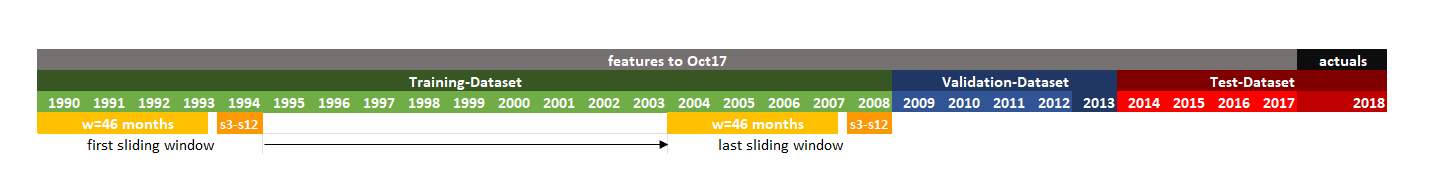

## Feed Forward Neural Network
Goal is to estimate the empirical distribution of the fatalities per month.
### Definition of the CRPS loss function and the Feed forward Neural Network subclass

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns

# crps loss function 
def crps(y_true, S):
    """
    Computes continuous ranked probability score:

    Parameters
    ----------
    y_true : tf tensor of shape (BATCH_SIZE, 1)
        True values.
    S : tf tensor of shape (BATCH_SIZE, N_SAMPLES)
        Predictive samples.

    Returns
    -------
    tf tensor of shape (BATCH_SIZE,)
        Scores.

    """
    beta=1
    n_samples = S.shape[-1]

    def expected_dist(diff, beta):
        return K.sum(K.pow(K.sqrt(K.square(diff)+K.epsilon()), beta),axis=-1) #axis = -1: last dimension <=> N_SAMPLES
    es_1 = expected_dist(y_true - S, beta)
    es_2 = 0
    for i in range(n_samples):
        es_2 = es_2 + expected_dist(K.expand_dims(S[:,i]) - S, beta)
    return es_1/n_samples - es_2/(2*n_samples**2)


class CRPSLoss(Loss):
    def call(self, y_true, S):
        return crps(y_true, S)

# Define custom ReLU activation function
class ReLUTransform(Layer):
    def call(self, inputs):
        return tf.nn.relu(inputs)

# Define the Feed Forward Neural Network subclass
class FeedForwardNN(tf.keras.Model):
    def __init__(self, input_shape, name="FeedFwdNN"):
        super(FeedForwardNN, self).__init__(name=name)
        
        self.hidden_layer1 = Dense(4, activation='relu')
        #self.hidden_layer2 = Dense(4, activation='relu')
        self.untransformed_output = Dense(200)
        self.final_output = Lambda(ReLUTransform())

        self.model = self.build(input_shape)
        
    def call(self, inputs):
        x = self.hidden_layer1(inputs)
        #x = self.hidden_layer2(x)
        x = self.untransformed_output(x)
        y = self.final_output(x)
        return y


### Estimation and Prediction

In [8]:
# Define hyperparameters
batchSize = 1
epochSize = 10
learningRate = 0.001

# Define inputs with predefined shape
input_shape = (len(X_train[0]),)
inputs = Input(shape=input_shape)
print(inputs.shape)

# Create an instance of the FeedForwardNN model
model = FeedForwardNN(input_shape=inputs.shape, name='FFwdNN_s3')

# Print model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=learningRate), loss=CRPSLoss())

(None, 4500)
Model: "FFwdNN_s3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  18004     
                                                                 
 dense_1 (Dense)             multiple                  1000      
                                                                 
 lambda (Lambda)             multiple                  0         
                                                                 
Total params: 19004 (74.23 KB)
Trainable params: 19004 (74.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
history = model.fit(X_train, Y_train, 
                    batch_size=batchSize, epochs=epochSize,
                    validation_data=(X_validate, Y_validate))


print('')
print('')

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test, batch_size=batchSize)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate prediction")
prediction = model.predict(X_test)
print("predictions shape:", prediction.shape)
empirical_distribution = np.round(np.sort(prediction[0])).astype(int)

Epoch 1/10
160/160 [==============================] - 23s 30ms/step - loss: 119.9912 - val_loss: 35.0913
Epoch 2/10
160/160 [==============================] - 1s 8ms/step - loss: 116.2383 - val_loss: 29.4531
Epoch 3/10
160/160 [==============================] - 1s 8ms/step - loss: 108.7860 - val_loss: 20.4679
Epoch 4/10
160/160 [==============================] - 1s 8ms/step - loss: 98.1534 - val_loss: 12.8973
Epoch 5/10
160/160 [==============================] - 1s 9ms/step - loss: 86.5845 - val_loss: 14.0527
Epoch 6/10
160/160 [==============================] - 1s 8ms/step - loss: 76.8867 - val_loss: 17.8319
Epoch 7/10
160/160 [==============================] - 1s 8ms/step - loss: 69.6321 - val_loss: 21.4052
Epoch 8/10
160/160 [==============================] - 1s 9ms/step - loss: 64.2091 - val_loss: 24.5230
Epoch 9/10
160/160 [==============================] - 1s 9ms/step - loss: 60.6309 - val_loss: 26.9821
Epoch 10/10
160/160 [==============================] - 1s 8ms/step - loss: 58

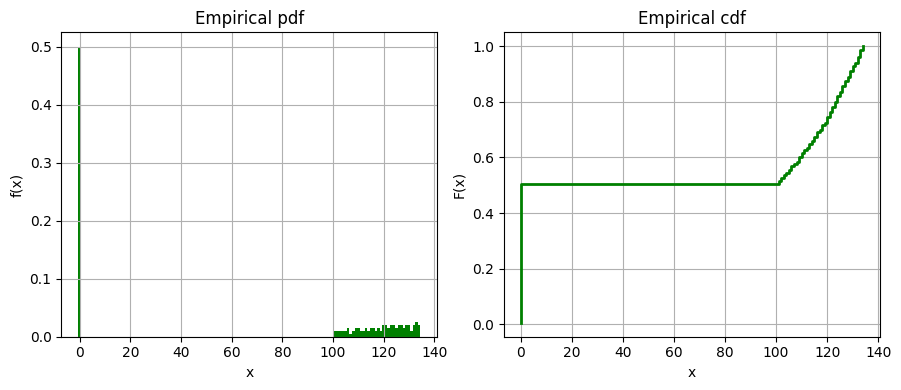

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def empirical_pdf(data):
    n = len(data)
    unique_values, counts = np.unique(data, return_counts=True)
    pdf_values = counts / n
    return unique_values, pdf_values

def empirical_cdf(data):
    n = len(data)
    ecdf_values = np.arange(1, n + 1) / n
    return ecdf_values

# Berechne die empirische pdf
unique_values, pdf = empirical_pdf(empirical_distribution)

# Berechne die empirische CDF
ecdf = empirical_cdf(empirical_distribution)

# Erstelle eine Figur mit 1 Zeile und 2 Spalten für die beiden Plots nebeneinander und kleiner
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# Plotte die empirische pdf im ersten Subplot
axes[0].bar(unique_values, pdf, width=1, align='center', alpha=1, color='green')
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[0].set_title('Empirical pdf')
axes[0].grid(True)

# Plotte die empirische CDF im zweiten Subplot
axes[1].step(empirical_distribution, ecdf, label='Empirical Density Function', color='green', linewidth=2)
axes[1].set_xlabel('x')
axes[1].set_ylabel('F(x)')
axes[1].set_title('Empirical cdf')
axes[1].grid(True)

plt.tight_layout()  # Optimiere den Abstand zwischen den Subplots
plt.show()


In [11]:
y_true = Y_test[0][0]
crps = pscore(empirical_distribution,y_true).compute()[0]
print('CRPS = ' + str(crps))

CRPS = 28.567050000000002
